In [1]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-_6tg8gro
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-_6tg8gro
  Resolved https://github.com/tensorflow/examples.git to commit 37df0b9a2f7240831642cea4380e4f7ec33bee83
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-37df0b9a2f7240831642cea4380e4f7ec33bee83_-py3-none-any.whl size=299718 sha256=349e928d534f4d743d289c8c9ec050ec95157a8fa5aa0cb5b1f4aa4b6a68ccfa
  Stored in directory: /tmp/pip-ephem-wheel-cache-1emkfwzx/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. pip 23.1 will enforce this behaviour change. A possible replacement is to

In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow_examples.models.pix2pix import pix2pix
import os
import cv2
import shutil
import PIL

import matplotlib.pyplot as plt
import numpy as np

In [3]:
print(tf.__version__)

2.11.0


### Building GANs using Monet's Paintings

This project is an attempt to apply Generative Adversarial Networks to replicate classical painting styles on modern images. I specifically state apply rather than create because most of the architecture and code design was inspired by available resources, specifically the following:

<br>Kaggle Tutorial CycleGAN https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial</br>
<br>TensorFlow Tutorial pix2pix https://www.tensorflow.org/tutorials/generative/pix2pix</br>
<br>TensorFlow Tutorial CycleGAN https://www.tensorflow.org/tutorials/generative/cyclegan</br>

We look at the number of tfrec files, these are easier to use with TF rather than the JPEGs

In [4]:
MONET_JPEG_DIR = '/kaggle/input/gan-getting-started/monet_jpg/'
PHOTOS_JPEG_DIR = '/kaggle/input/gan-getting-started/photo_jpg/'
MONET_DIR = '/kaggle/input/gan-getting-started/monet_tfrec/'
IMAGES_DIR = '/kaggle/input/gan-getting-started/photo_tfrec/'

MONET_FILES = os.listdir(MONET_DIR)
IMAGES_FILES = os.listdir(IMAGES_DIR)
print(len(MONET_FILES), len(IMAGES_FILES))

5 20


There are 5 Monet TFR files and 20 Photo TFR files. Looking at the JPEG counts we see **300 Monet Paintings** and **7000 Images** all of size **256x256**

Example of some Monet's

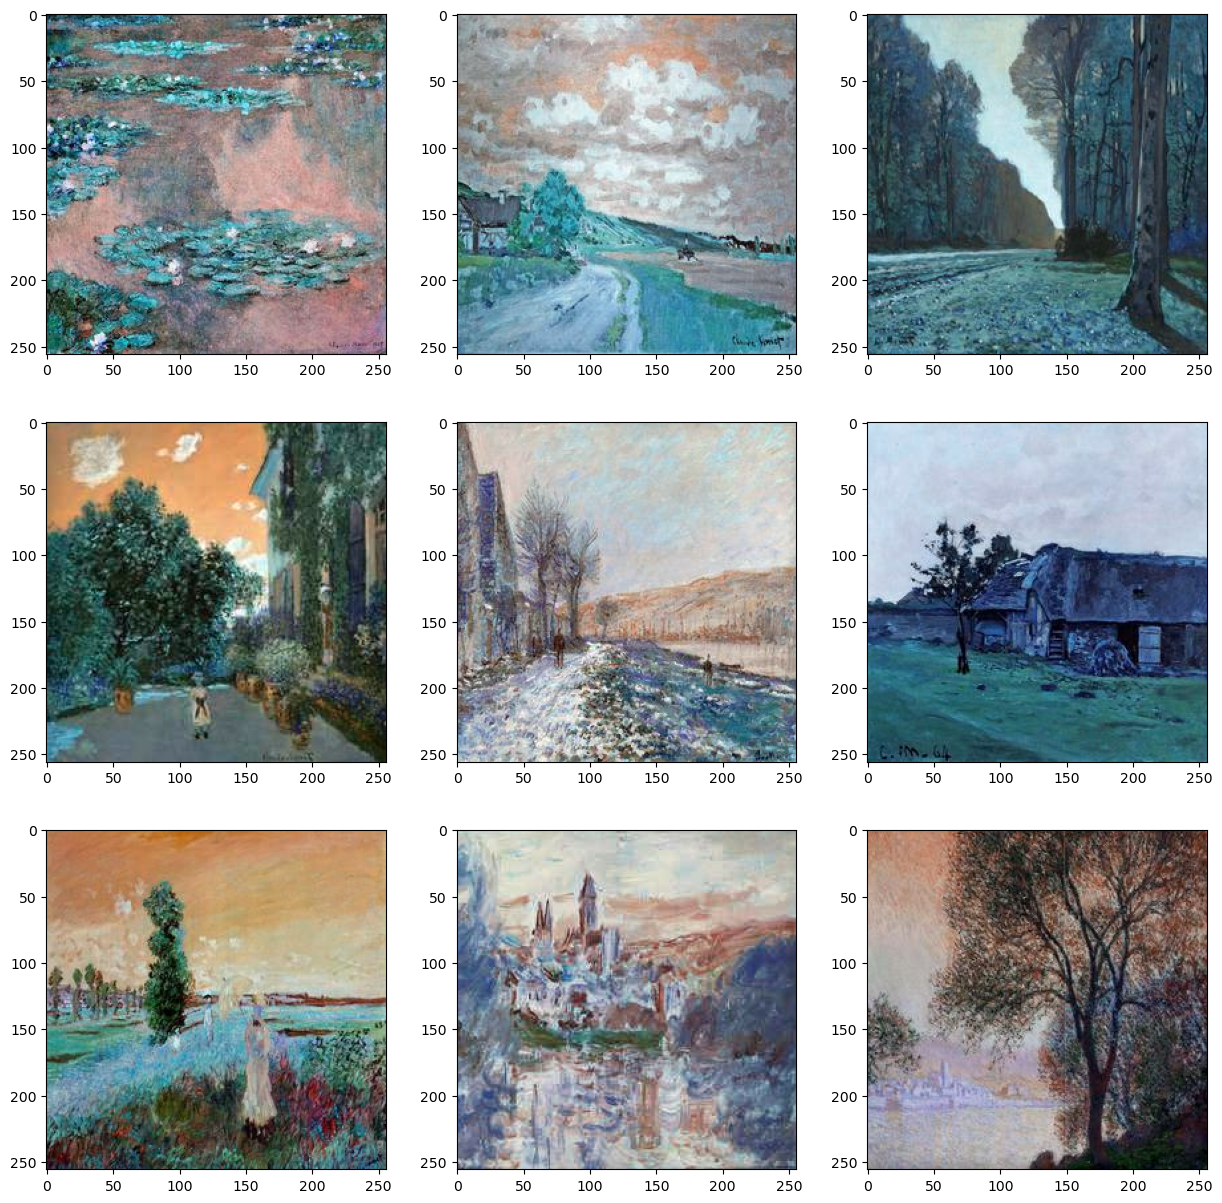

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
axs = axs.flatten()
for image, axis in zip(os.listdir(MONET_JPEG_DIR)[:9], axs):
    img = cv2.imread(MONET_JPEG_DIR+image) 
    axis.imshow(img)

Examples of some photos

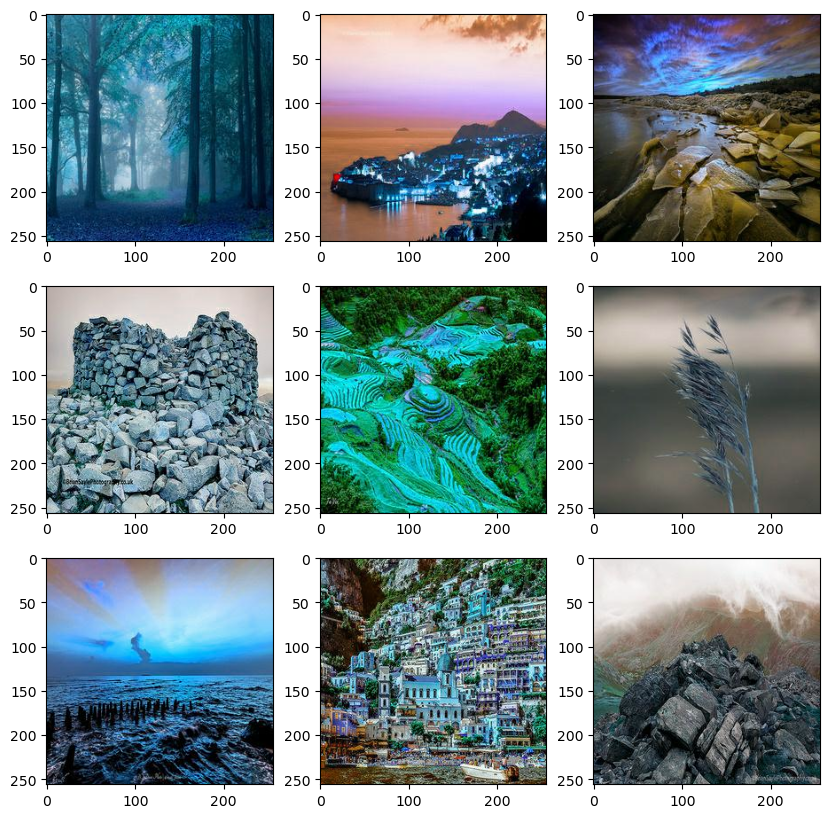

In [6]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
axs = axs.flatten()
for image, axis in zip(os.listdir(PHOTOS_JPEG_DIR)[:9], axs):
    img = cv2.imread(PHOTOS_JPEG_DIR+image) 
    axis.imshow(img)

We utilize some helper functions to read the TFR data.

In [7]:
BATCH_SIZE = 1
IMAGE_SIZE = (256, 256, 3)
buffer_size = 1000
AUTOTUNE = tf.data.experimental.AUTOTUNE

def normalize_image(image):
    image = tf.cast(image, dtype=tf.float32)
    return (image / 127.5) - 1.0

def preprocess_train_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image, [*orig_image_size])
    image = tf.image.random_crop(image, size=[*IMAGE_SIZE])
    image = normalize_image(image)
    return image

def preprocess_test_image(image, label):
    image = tf.image.resize(image, [input_image_size[0], IMAGE_SIZE[1]])
    image = normalize_image(image)
    return image

def read_tfrecord(item):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string),
    }
    item = tf.io.parse_single_example(item, features)
    image = tf.image.decode_jpeg(item['image'], channels=3)
    return tf.reshape(image, [256, 256, 3])

def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

monet_ds = load_dataset([MONET_DIR+x for x in MONET_FILES])
photo_ds = load_dataset([IMAGE_DIR+x for x in IMAGE_FILES])

In [8]:
monet_train = monet_ds.take(250).batch(BATCH_SIZE)
monet_test = monet_ds.skip(250).take(50).batch(BATCH_SIZE)

photo_train = photo_ds.take(6038).batch(BATCH_SIZE)
photo_test = photo_ds.skip(6038).take(1000).batch(BATCH_SIZE)

In [9]:
monet_train

<BatchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>

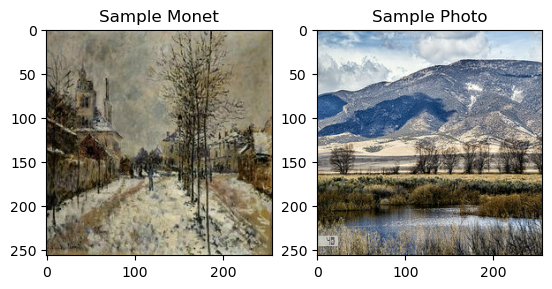

In [11]:
# Plot some samples of the data we just read
sample_monet = next(iter(monet_train))
sample_photo = next(iter(photo_train))

plt.subplot(121)
plt.title('Sample Monet')
plt.imshow(sample_monet[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Sample Photo')
plt.imshow(sample_photo[0] * 0.5 + 0.5)

In [ ]:
# Utilize the p2p package installed at the beggining from
# https://keras.io/examples/generative/cyclegan/#building-blocks-used-in-the-cyclegan-generators-and-discriminators

# Generators
gen_G = p2p.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
gen_F = p2p.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# Discriminators
disc_X = p2p.discriminator(norm_type='instancenorm', target=False)
disc_Y = p2p.discriminator(norm_type='instancenorm', target=False)

In [18]:
# visualize the structure
generator_M.summary()

Model: "gen_G"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 gen_G_img_input (InputLayer)   [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reflection_padding2d (Reflecti  (None, 262, 262, 3)  0          ['gen_G_img_input[0][0]']        
 onPadding2D)                                                                                     
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  9472        ['reflection_padding2d[0][0]']   
                                )                                                             

In [19]:
class CycleGan(tf.keras.Model):
    """CycleGAN Model as implemented on the Kaggle Resource
     https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook"""
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn

        self.cycle_loss_fn = tf.keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is monet
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:

            # Generator G translates X -> Y
            # Generator F translates Y -> X.

            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)

            # Cycle
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_real_y = self.disc_Y(real_y, training=True)

            disc_fake_x = self.disc_X(fake_x, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Calculate the gradients for generator and discriminator
        generator_G_gradients = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        generator_F_gradients = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        discriminator_X_gradients = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        discriminator_Y_gradients = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Apply the gradients to the optimizer
        self.gen_G_optimizer.apply_gradients(
            zip(generator_G_gradients, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(generator_F_gradients, self.gen_F.trainable_variables)
        )

        self.disc_X_optimizer.apply_gradients(
            zip(discriminator_X_gradients, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(discriminator_Y_gradients, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [20]:
class GANMonitor(tf.keras.callbacks.Callback):
    """Call Back Function to save the images"""
    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_train.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
        plt.show()
        plt.close()

In [21]:
def generator_loss_fn(fake):
    """Generator Loss"""
    return tf.keras.losses.MeanSquaredError(tf.ones_like(fake), fake)

def discriminator_loss_fn(real, fake):
    """Discriminator Loss"""
    real_loss = tf.keras.losses.MeanSquaredError(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.MeanSquaredError(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) / 2

Epoch 1/2
    250/Unknown - 199s 448ms/step - G_loss: 5.0312 - F_loss: 5.6945 - D_X_loss: 0.0972 - D_Y_loss: 0.1244

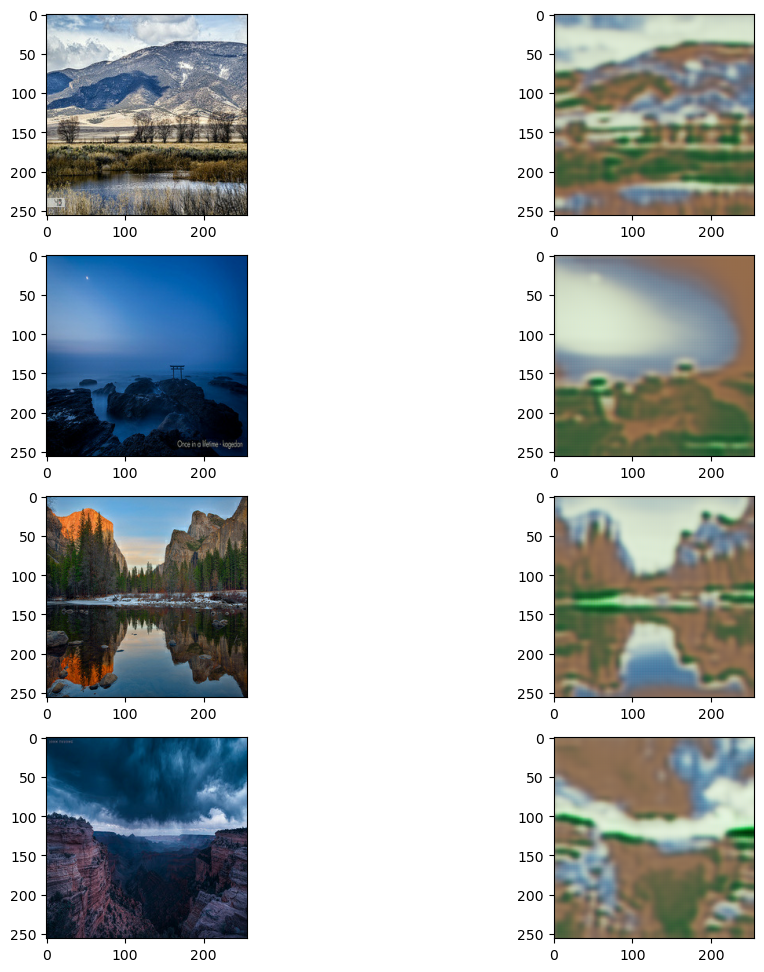

250/250 [==============================] - 200s 454ms/step - G_loss: 5.0401 - F_loss: 5.6933 - D_X_loss: 0.0968 - D_Y_loss: 0.1243
Epoch 2/2
250/250 [==============================] - ETA: 0s - G_loss: 4.7318 - F_loss: 5.0370 - D_X_loss: 0.1768 - D_Y_loss: 0.1531

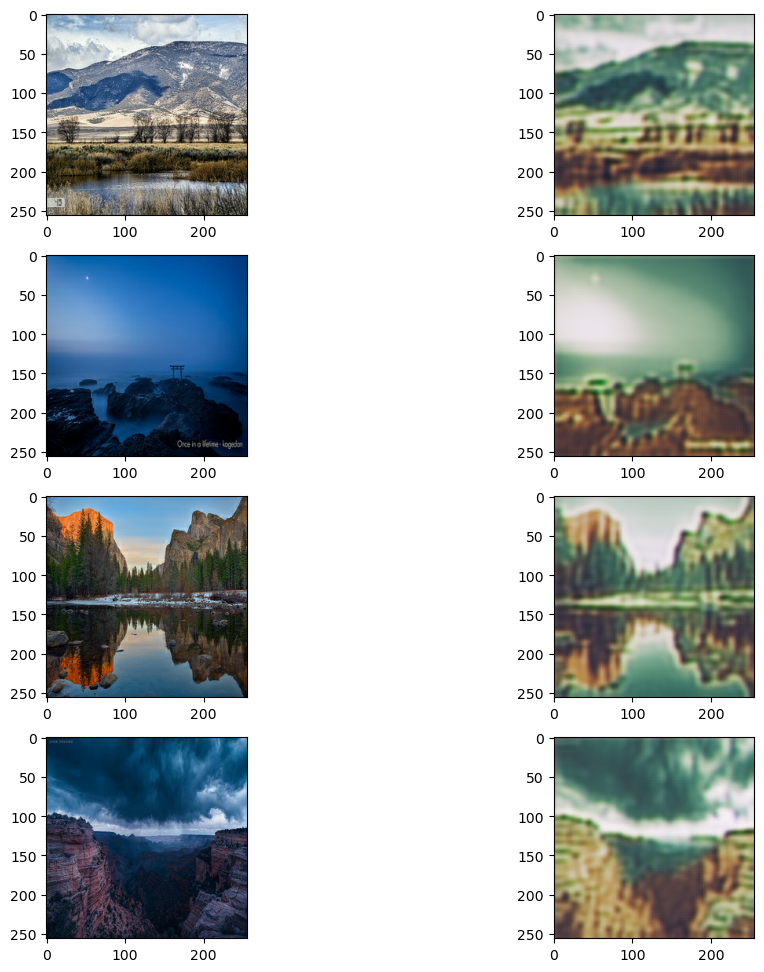

250/250 [==============================] - 114s 455ms/step - G_loss: 4.7415 - F_loss: 5.0353 - D_X_loss: 0.1764 - D_Y_loss: 0.1530


In [23]:
cycle_gan_model = CycleGan(
    generator_G=gen_G,
    generator_F=gen_F,
    discriminator_X=disc_X,
    discriminator_Y=disc_Y,
)

cycle_gan_model.compile(
    gen_G_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_F_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_X_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    disc_Y_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_train, monet_train)),
    epochs=5,
    callbacks=GANMonitor(),
)

We see the images looking more and more like actual paintings. A few more epochs and we are ready to submit.

In [ ]:
!mkdir -p /kaggle/images

In [ ]:
index = 0

for index, img in enumerate(photo_ds.batch(1)):
    prediction = gen_G(img, training=False).numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    for pred in prediction:
        im = PIL.Image.fromarray(pred)
        im.save(f"/kaggle/images/{index}.jpg")
        index += 1
print(index)

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

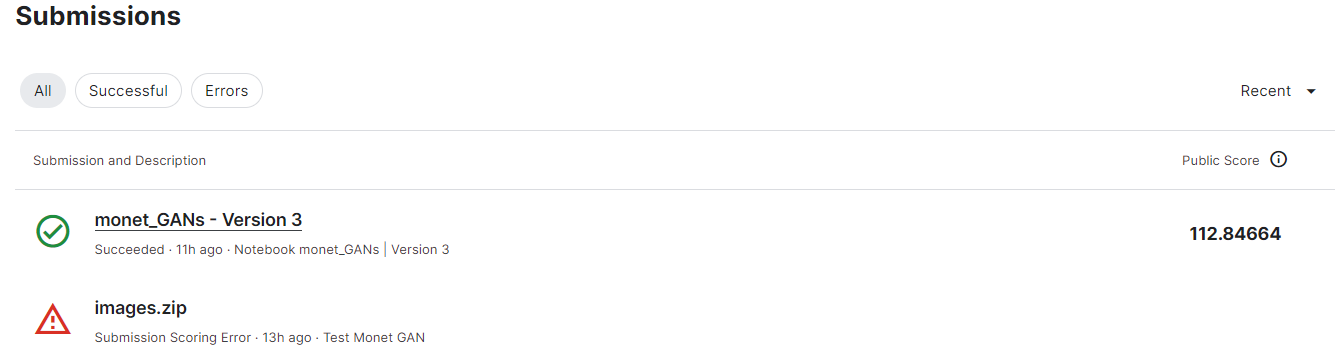